In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from scipy import stats 
import env
import wrangle
import explore
from itertools import combinations


# Executive Summary

# The plan for this presentation: 
- Acquiring and preparing the data
- Exploration of different factors that could contribute to the tax value dollar amount
- Testing different models
- Final recommendations 

# Acquiring and Preparing the data

### This wrangle function acquires the data and prepares it by doing the following:

- acquires Single Family Residential units from the properties_2017, propertylandusetype, and predictions_2017 tables, which was taken from the Zillow database
- drops the na values to get rid of nulls 
- converts the columns bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, and yearbuilt to int columns
- gets rid of properties that have zero bedrooms or more than 6 bedrooms
- gets rid of properties that have zero bathrooms or more than 6 bathrooms
- gets rid of properties where the tax value dollar count exceeds 4,000,000
- gets rid of properties where the calculated finished square feet is over 100,000
- adds a fips two colummn that gives the name of the county that is represented by the fips number: 
    - 6037 = LA 
    - 6059 = Orange 
    - 6111 = Ventura
- adds an age column, that gives the age of the property in years

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid,age,fips2
0,4,2.5,2490,691000,1969,7138.64,Orange,14381521,53,6059
1,4,2.0,1808,241131,1980,3589.81,LA,11108702,42,6037
2,4,2.0,1878,94598,1965,1415.77,LA,10728687,57,6037
3,4,2.0,1207,380736,1964,3869.62,Orange,14376191,58,6059
4,2,1.0,728,33497,1925,974.63,LA,12391744,97,6037


In [4]:
df.shape


(51702, 10)

In [5]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
parcelid                        0
age                             0
fips2                           0
dtype: int64

<div class="alert alert-block alert-success">
<b>Success:</b> All data was pulled and prepared as expected.
</div>

# Split the Data

In [6]:
# This function pulls from the wrangle.py file and splits the data into train, validate, and test
# This will be used in the exploration

train, validate, test = wrangle.split_zillow_data(df)

train.shape, validate.shape, test.shape

((28952, 10), (12409, 10), (10341, 10))

In [7]:
# Stratify with taxvaluedollarcnt
X_train = train.drop(columns=["taxvaluedollarcnt"])
y_train = train.taxvaluedollarcnt

X_validate = validate.drop(columns=["taxvaluedollarcnt"])
y_validate = validate.taxvaluedollarcnt

X_test = test.drop(columns=["taxvaluedollarcnt"])
y_test = test.taxvaluedollarcnt

<div class="alert alert-block alert-success">
<b>Success:</b> Data was split into train, validate, test samples as expected.
</div>

# Exploration

#### The target variable is tax value dollar count
### Hypothesis
- county (fips) has a strong relationship with tax value dollar count (tvd)
- calculated finished square feet (sqft) has a strong relationship with tvd
- newer homes have a higher tvd 
- homes with more bedrooms and bathrooms have a higher tvd (probably has a strong correlation with sqft
- LA county has the highest value homes, followed by orange then ventura


In [8]:
# first lets see what columns may be correlated to our target variable
columns_corr = train.corr()
columns_corr.taxvaluedollarcnt

bedroomcnt                      0.277196
bathroomcnt                     0.533649
calculatedfinishedsquarefeet    0.602603
taxvaluedollarcnt               1.000000
yearbuilt                       0.221701
taxamount                       0.982508
parcelid                        0.030878
age                            -0.221701
fips2                           0.059124
Name: taxvaluedollarcnt, dtype: float64

- Takeaway: 
When looking at the tax value dollar count, we can see that it is strongly related to tax amount. This strong of a relationship would skew our analysis, so when looking for our target variable we will be ignoring the tax amount. 

In [9]:
# Here I am going to create 3 different variables. The first (or base) will contain just the bathroom count, bedroom count, age, and square feet
# The second will contain the same as the first, but with the tax value dollar count
# The third will contain the base, but with the fips county names
interest_vars_base= (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age)
interest_vars_v= (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age, train.taxvaluedollarcnt)
interest_vars_f = (train.bedroomcnt, train.bathroomcnt, train.calculatedfinishedsquarefeet, train.age, train.fips)

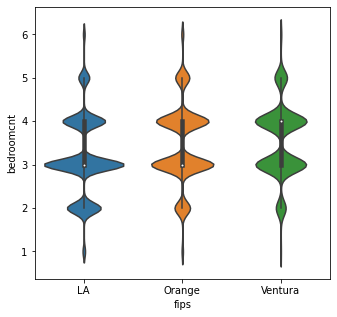

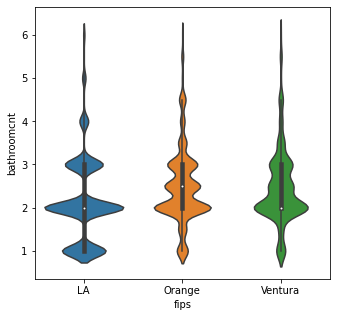

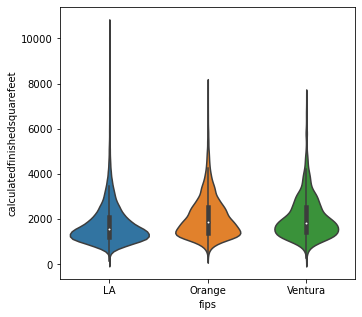

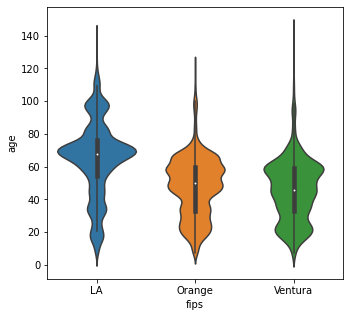

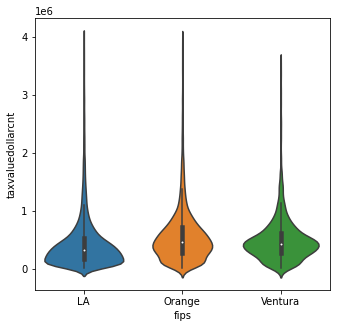

In [10]:
# Here I want to look at each county against my base variables 
explore.fips_vs_continuous_vars(train, interest_vars_v,['fips'])

In [11]:
train.age.mean()

58.81680022105554

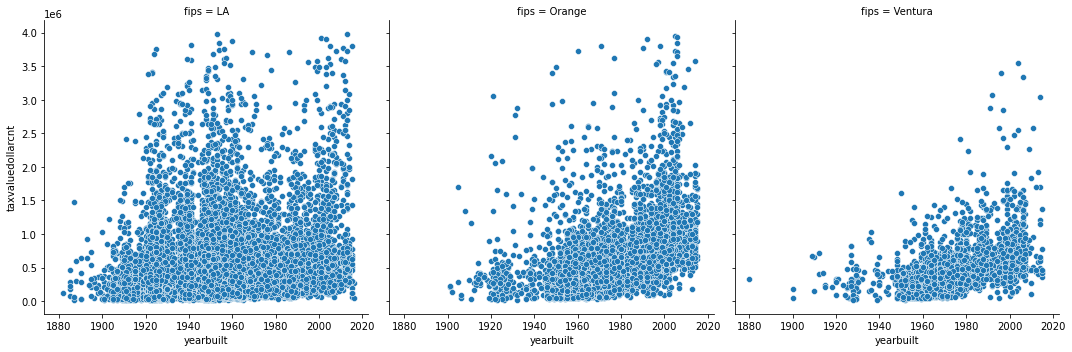

In [18]:
sns.relplot(x="yearbuilt", y="taxvaluedollarcnt", data=train,  kind='scatter', height=5, col='fips')
plt.show()

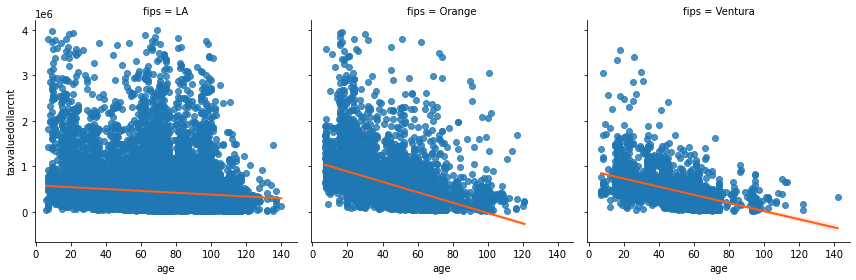

In [24]:
sns.lmplot(x = 'age', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2}, height = 4, col = 'fips')

Takeaway: Properties in LA county seem to hold their value significantly better as they age versus properties in Orange county and Ventura county

In [25]:
alpha = .05
corr, p = stats.pearsonr(train.age, train.taxvaluedollarcnt)
p< alpha, corr

(True, -0.22170107312039883)